In [1]:
import os
import re
import pathlib
from glob import glob

import matplotlib.pyplot as plt
import earthaccess
import xrspatial
import geopandas as gpd
import rioxarray as rxr
import rioxarray.merge as rxrmerge

c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
%store -r comanche_gdf pawnee_gdf c_soil_url_list p_soil_url_list

In [3]:
# build project and elevation directories

data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data'
)
project_dir = os.path.join(data_dir, 'habitat_suitability')
elevation_dir = os.path.join(data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

In [4]:
# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [5]:
# search for the appropriate DEM

datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


In [6]:
# Define a pattern to identify DEM tiles associated with Comanche National Grassland.
srtm_c_pattern = os.path.join(elevation_dir, 'N36*hgt.zip' and 'N37*hgt.zip')
bounds_c = tuple(comanche_gdf.total_bounds)
if not glob(srtm_c_pattern):
    srtm_c_results = earthaccess.search_data(
        short_name = "SRTMGL1",
        bounding_box=bounds_c    
    )
    srtm_c_results = earthaccess.download(srtm_c_results, elevation_dir)

CRSError: Invalid projection: EPSG:4269: (Internal Proj Error: proj_create: no database context specified)

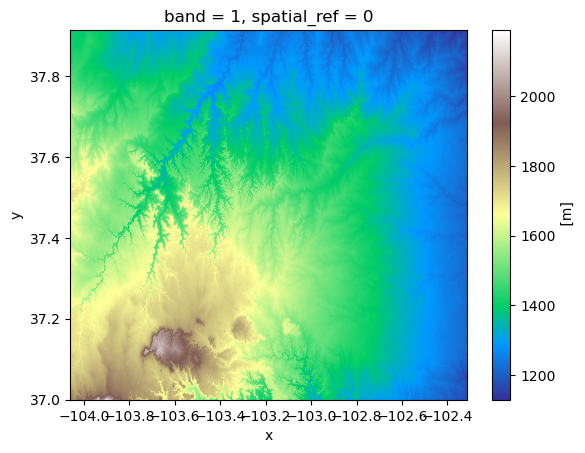

In [7]:
# Print the DEM for Comanche natl. Grassland
srtm_c_da_list=[]
for srtm_c_path in glob(srtm_c_pattern):
    tile_da = rxr.open_rasterio(srtm_c_path, mask_and_scale=True).squeeze()
    cropped_da = tile_da.rio.clip_box(*bounds_c)
    srtm_c_da_list.append(cropped_da)
    
srtm_c_da = rxrmerge.merge_arrays(srtm_c_da_list)
srtm_c_da.plot(cmap='terrain')
comanche_gdf.boundary.plot(ax=plt.gca(), color='black')

In [ ]:
# # This is some test code I'm using to try and fix the Pawnee DEM
# srtm_t_path = os.path.join(elevation_dir, 'N41W105.SRTMGL1.hgt.zip')
# tile_da = rxr.open_rasterio(srtm_t_path, mask_and_scale=True).squeeze()
# tile_da.plot()

In [ ]:
# # define a pattern which identifies the DEM's belongning to Pawnee National Grasslands

# srtm_p_pattern = os.path.join(elevation_dir, 'N40*hgt.zip' and 'N41*hgt.zip')
# bounds_p = tuple(pawnee_gdf.total_bounds)
# if not glob(srtm_p_pattern):
#     srtm_p_results = earthaccess.search_data(
#         short_name = "SRTMGL1",
#         bounding_box=bounds_p    
#     )
#     srtm_p_results = earthaccess.download(srtm_p_results, elevation_dir)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

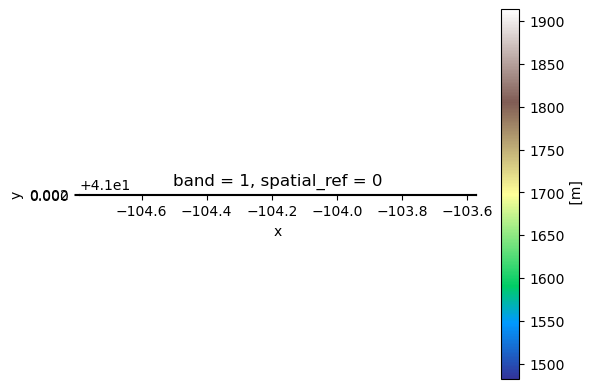

In [ ]:
# # Print the DEM for Pawnee natl. Grassland
# srtm_p_da_list=[]
# for srtm_p_path in glob(srtm_p_pattern):
#     tile_da = rxr.open_rasterio(srtm_p_path, mask_and_scale=True).squeeze()
#     cropped_da = tile_da.rio.clip_box(*bounds_p)
#     srtm_p_da_list.append(cropped_da)
    
# srtm_p_da = rxrmerge.merge_arrays(srtm_p_da_list)
# srtm_p_da.plot(cmap='terrain')
# pawnee_gdf.boundary.plot(ax=plt.gca(), color='black')

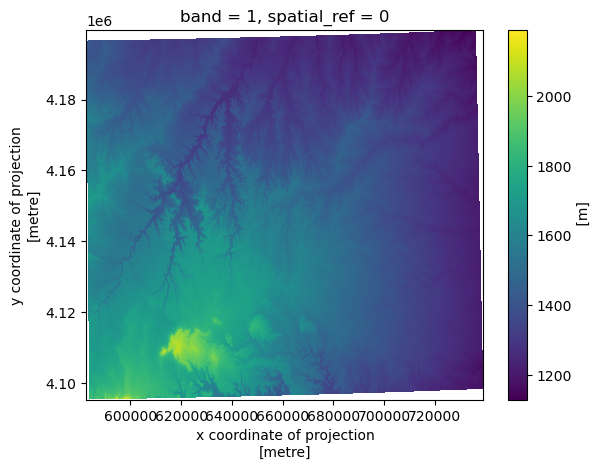

In [ ]:
utm_13n_epsg = 32613
srtm_c_proj_da = srtm_c_da.rio.reproject(utm_13n_epsg)
# srtm_p_proj_da = srtm_da.to_crs()
srtm_c_proj_da.plot()

MemoryError: Unable to allocate 184. MiB for an array with shape (4011, 6005) and data type float64

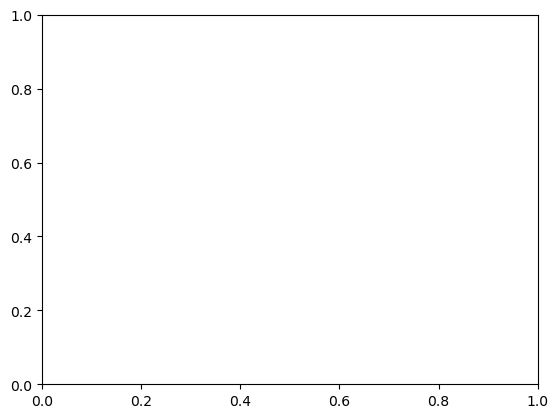

In [ ]:
slope_c_da = xrspatial.slope(srtm_c_proj_da)
slope_c_da.plot(cmap='terrain')
comanche_gdf.boundary.to_crs(utm_13n_epsg).boundary.plot(ax=plt.gca(), color='white')